In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2

In [33]:
# Sampling.
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# Input.
batch_size = 8
image_size = 256
channels = 1

In [125]:
def diffusion_schedule(diffusion_times):
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

def reverse_diffusion(model, num_images, diffusion_steps, initial_noise = None):
    if initial_noise == None:
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, channels))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2], training = True)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [49]:
def display_image(image):
    temp = image.reshape((256, 256))
    plt.imshow(temp, cmap='gray')

In [34]:
model = keras.models.load_model('../data/models/diffusion_models/diffusion1_epoch70')

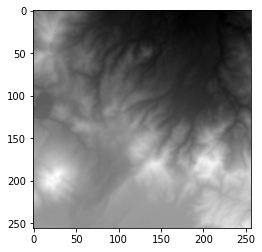

In [97]:
base_image = cv2.imread('../data/images/test_images/test.png', 0)
base_image = np.asarray(base_image)
base_image = base_image.reshape((1, 256, 256, 1))
base_image = base_image / 255
display_image(base_image)

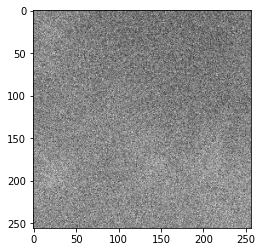

In [143]:
noise = tf.random.normal(shape = (1, 256, 256, 1))
signal_rate = 0.7
noise_rate = 1 - signal_rate
noisy_image = signal_rate * base_image + noise_rate * noise
display_image(noisy_image.numpy())

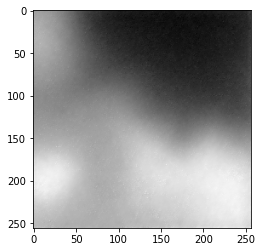

In [152]:
generated_images = reverse_diffusion(model, 1, 20, noisy_image).numpy()
display_image(generated_images[0])

In [153]:
generated_images[0][0][:10]

array([[18.8137  ],
       [18.75846 ],
       [18.781551],
       [18.70188 ],
       [19.182028],
       [18.846222],
       [19.00996 ],
       [18.823828],
       [18.861689],
       [18.850851]], dtype=float32)

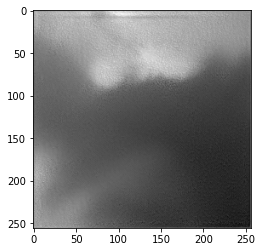

In [146]:
generated_images = reverse_diffusion(model, 1, 20).numpy()
display_image(generated_images[0])

In [150]:
generated_images[0][0][:10]

array([[0.45871726],
       [0.48958436],
       [0.5288524 ],
       [0.5732447 ],
       [0.56126505],
       [0.5096026 ],
       [0.50676054],
       [0.53285927],
       [0.49900296],
       [0.5060735 ]], dtype=float32)